# COGS 118B - Final Project

# Contributing Factors to Obesity

## Group members

- Pallavi Gaikwad
- Katelyn Vu
- Austin Jung
- William Kim
- Kayla Nguyen

# Abstract 
Our goal is to analyze and identify the salient eating habits, lifestyle choices, and any genetic predispositions of individuals that generally lead to obesity. We are using tabular data from the UCI Machine Learning Data Repository with data about individuals and obesity from Mexico, Peru, and Colombia. Some of the metrics in the dataset include family history of overweight, daily meal count, and time spent physically active. We plan to perform model selection from unsupervised and supervised machine learning algorithms to identify any trends or clustering of data, specifically k-nearest neighbors, k-means clustering, DBSCAN, and decision tree classification. We evaluated our supervised algorithms using accuracy scores and our unsupervised algorithms using silhouette scores, and found that the supervised classification model performed significantly better, producing a 95% accuracy score in the final model. This shows that using the features given we can very accurately obesity levels with classification rather than clustering.



# Background
Obesity is a widespread global health crisis that causes severe health complications and costs billions of dollars annually in treatments. As of 2016, about 340 million people were classified as obese and 1.9 billion were classified as overweight<a name="who"></a>[<sup>[1]</sup>](#who). In the United States, obesity disproportionately affects certain racial groups at higher rates; non-Hispanic Black adults showed an obesity prevalence of roughly 49% and Hispanic adults showed an obesity prevalence of roughly 45%<a name="cdc"></a>[<sup>[2]</sup>](#cdc). Obesity also demonstrates higher rates of prevalence based on socioeconomic status, with college graduates showing lower rates of obesity when compared to adults with less education─this further breaks down when taking into account sex and race. This epidemic does not solely apply to adults as roughly 340 million children were diagnosed as either obese or overweight in 2016<a name="who"></a>[<sup>[1]</sup>](#who).

These staggering proportions are extremely alarming as obesity increases the risk of other severe health conditions, such as heart disease, stroke, type II diabetes, and some types of cancer (colon, prostate, and rectum cancer in men and breast, uterine, and gallbladder cancer in women)<a name="niddk"></a>[<sup>[3]</sup>](#niddk). Not only are these conditions harmful, they also increase financial burden. In the United States, those who are overweight or obese pay on average $2000 more annually in healthcare costs than those at healthy weights<a name="cdc"></a>[<sup>[2]</sup>](#cdc). 

Even with these sobering statistics, obesity trends have continued to increase amongst all age groups, sexes, and racial groups, with global obesity nearly tripling since 1975<a name="who"></a>[<sup>[1]</sup>](#who). The causes of obesity are a mix of both genetic and environmental factors, such as diet, physical activity, and sedentary behavior.  This is an extremely prevalent issue and one of the most pressing healthcare crises facing Americans, so in this project we hope to see which factors may be contributing more to obesity prevalence.

# Problem Statement

Our team’s objective is to analyze and identify the salient eating habits, lifestyle choices, and physical traits of individuals that generally lead to certain types of obesity. We want to see if certain classifications have one or two common variables that can center clusters or if classification is better determined by all features for observations. This challenge involves the development of a machine learning model capable of segmenting our observations into distinct groups.

# Data
'https://archive.ics.uci.edu/dataset/544/estimation+of+obesity+levels+based+on+eating+habits+and+physical+condition'

Our dataset was pulled from the UCI Machine Learning Repository. A link to this can be found above. The dataset itself is the result of a survey that collected information on obesity levels from individuals in the countries of Mexico, Peru, and Colombia.

It contains 2111 records containing 17 attributes (16 features and 1 column with labels):
- `Gender`: Male, Female
- `Age`: Numeric
- `Height`: Numeric in meters
- `Weight`: Numeric in kilograms
- `Family_history_with_overweight`: Yes, No
- `FAVC` (Do you eat high caloric food): Yes, No
- `FCVC` (Do you usually eat vegetables): Yes, No
- `NCP` (How many meals do you have daily): Between 1 and 2, Three, More than three
- `CAEC` (Do you eat food between meals): No, Sometimes, Frequently, Always
- `SMOKE` (Do you smoke): Yes, No
- `CH2O` (How much water do you drink):  Less than a liter, Between 1 and 2L, More than 2L
- `SCC` (Do you monitor your calories): Yes, No
- `FAF` (How often do you have physical activity): I do not have, 1 or 2 days, 2 or 5 days, 4 or 5 days
- `TUE` (How much time do you use technological devices): 0-2 hours, 3-5 hours, More than 5 hours
- `CALC` (How often do you drink alcohol): I do not drink, Sometimes, Frequently, Always
- `MTRANS` (Which transportation do you usually use): Automobile, Motorbike, Bike, Public Transportations, Walking
- `NObeyesdad`: Obesity Level	

One important aspect of this is that the researchers utilized a synthetic minority over-sampling technique to generate additional data in order to balance the number of identifiable samples for each type of obesity. This was done to decrease bias in future learning approaches.


### Data Cleaning

Below we read in our dataset, check for any missingness, and change column names. Overall we start by getting an understanding of our data.

In [14]:
# importing all necessary libraries

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import linear_model
import statsmodels.api as sm
from umap import UMAP 
from sklearn.decomposition import PCA, KernelPCA
from sklearn.manifold import TSNE
from sklearn.metrics import classification_report, adjusted_rand_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier, NearestNeighbors
from sklearn.pipeline import Pipeline
from sklearn.datasets import fetch_openml
from sklearn.cluster import DBSCAN
import sklearn.cluster as cluster
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder, OneHotEncoder


# suppresses annoying errors
import os
import sys

# Redirect stderr to /dev/null (Linux/macOS) or nul (Windows)
if os.name == 'posix':
    sys.stderr = open(os.devnull, 'w')
elif os.name == 'nt':
    sys.stderr = open('nul', 'w')

In [2]:
# reading in dataset
obesity=pd.read_csv('obesity.csv')

# renaming variable columns 

obesity.rename(columns={'family_history_with_overweight': 'Family Obesity', 
                        'FAVC': 'High Calories', 
                        'FCVC': 'Vegetables', 
                        'NCP': 'Meals',
                        'CAEC': 'Food Between Meals',
                        'SMOKE': 'Smoke',
                        'CH2O': 'Water',
                        'SCC': 'Monitor Calories',
                        'FAF': 'Exercise',
                        'TUE': 'Technology',
                        'CALC': 'Alcohol',
                        'MTRANS': 'Transportation'
                        }, inplace=True)

# snapshot of dataset
obesity.head()


,Gender,Age,Height,Weight,Family Obesity,High Calories,Vegetables,Meals,Food Between Meals,Smoke,Water,Monitor Calories,Exercise,Technology,Alcohol,Transportation,NObeyesdad
0,Female,21.0,1.62,64.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,0.0,1.0,no,Public_Transportation,Normal_Weight
1,Female,21.0,1.52,56.0,yes,no,3.0,3.0,Sometimes,yes,3.0,yes,3.0,0.0,Sometimes,Public_Transportation,Normal_Weight
2,Male,23.0,1.80,77.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,2.0,1.0,Frequently,Public_Transportation,Normal_Weight
3,Male,27.0,1.80,87.0,no,no,3.0,3.0,Sometimes,no,2.0,no,2.0,0.0,Frequently,Walking,Overweight_Level_I
4,Male,22.0,1.78,89.8,no,no,2.0,1.0,Sometimes,no,2.0,no,0.0,0.0,Sometimes,Public_Transportation,Overweight_Level_II


### Data Preprocessing for Evaluation

Below we standardize all numerical columns, so each feature is on the same scale, and we one hot encode our categorical columns. We need to one hot encode our categorical columns so that we are able to run the machine learning algorithms using our categorical features. WE chose to one hot encode our columns over label encoding because we did not want the model to assign higher weights to features, and value those weights more in our algorithm. One hot encoding expanded our feature number from 16 features to 31.

In [3]:
# identify the numerical columns
numerical_columns = ['Age', 'Height', 'Weight', 'Vegetables', 'Meals', 'Water', 'Exercise', 'Technology']

# standardize numerical columns
scaler = StandardScaler()
obesity[numerical_columns] = scaler.fit_transform(obesity[numerical_columns])

# Identify the categorical columns to be one-hot encoded
categorical_columns = ['Gender', 'Family Obesity', 'Food Between Meals', 'High Calories', 'Smoke', 'Monitor Calories', 'Transportation', 'Alcohol']

# Perform one-hot encoding
ohe = OneHotEncoder()
ohe_vals = ohe.fit_transform(obesity[categorical_columns]).toarray()
ohe_vals_cols = ohe.get_feature_names_out(categorical_columns)

# Display the preprocessed DataFrame
cleaned_df = obesity.drop(columns=categorical_columns)
cleaned_df[ohe_vals_cols] = ohe_vals
cleaned_df.head()

,Age,Height,Weight,Vegetables,Meals,Water,Exercise,Technology,NObeyesdad,Gender_Female,...,Monitor Calories_yes,Transportation_Automobile,Transportation_Bike,Transportation_Motorbike,Transportation_Public_Transportation,Transportation_Walking,Alcohol_Always,Alcohol_Frequently,Alcohol_Sometimes,Alcohol_no
0,-0.522124,-0.875589,-0.862558,-0.785019,0.404153,-0.013073,-1.188039,0.561997,Normal_Weight,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1,-0.522124,-1.947599,-1.168077,1.088342,0.404153,1.618759,2.339750,-1.080625,Normal_Weight,1.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
2,-0.206889,1.054029,-0.366090,-0.785019,0.404153,-0.013073,1.163820,0.561997,Normal_Weight,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
3,0.423582,1.054029,0.015808,1.088342,0.404153,-0.013073,1.163820,-1.080625,Overweight_Level_I,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
4,-0.364507,0.839627,0.122740,-0.785019,-2.167023,-0.013073,-1.188039,-1.080625,Overweight_Level_II,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0


# Proposed Solution
To address the problem of identifying factors contributing to different levels of obesity, we propose that we will be able to utilize k-means clustering based on eating habits, lifestyle choices, and physical traits. This algorithm allows us to partition our data into predetermined clusters where each data point, or individual, will belong to one level of obesity. This will allow us to uncover underlying patterns within the dataset. 

The data set that we have chosen to use comprises various features related to eating habits, lifestyle,  physical traits, and corresponding Body Mass Indexes (BMIs) of individuals. These features will allow us to perform analysis that will capture the determinants of obesity. Some of these variables are categorical so we will need to utilize one-hot encoding. Since K means relies on the calculation of distances between data points, we will have to preprocess the data to ensure that it is appropriately scaled and normalized.  We will apply the algorithm to segment the dataset into distinct groups based on similarities in the features. Assuming that we find the number of clusters that maximize intra-cluster similarity and inter-cluster dissimilarity, we will be able to analyze the characteristics of each cluster to identify common trends associated with different types of obesity. To test our solution we will split the data set into testing and training subsets and compare the results of our model and existing knowledge of obesity.

If the data does not support the use of a K Means model then we will explore other clustering algorithms and a classification model like a decision tree classifier. Since our data will already be preprocessed, it is easy for us to implement many machine learning algorithms and compare their performance to find the best performing model.

Overall, our solution aims to provide insights for public health strategies that can prevent and manage obesity levels. It will allow us to identify distinct groups of individuals based on different features and enable a deeper understanding of the factors that contribute to different types of obesity.

# Evaluation Metrics

## Unclassified Clustering Evaluation Metric: Silhouette Score

The main evaluation metric that will be used for our clustering models is the `silhouette score`. By using the separation distance between the clusters within the model, we can determine the optimal number of clusters. The two categories to take into account are the thickness of the silhouette scores plotted (namely how thick they are compared to the other clusters’ scores), and how close the silhouette scores of each cluster is to 1, which would indicate that the cluster is far away from the other clusters.

In order to calculate the silhouette coefficient for each of the samples, we need to find the following: the mean intra-cluster distance (a) and the mean nearest-cluster distance (b). To find these two distances, we would use the distance formula between each of the points in the cluster with all other points in the cluster. Therefore, $$a(i) =\frac{ \sum_{j \in C_i, j\neq i}dist(i,j)}{N_i-1}$$
for each sample $i$, in cluster $C_i$, where $j$ is the other points within $C_i$, and $N_i$ is the total number of samples within $C_i$.

On the other hand, we can find b with a similar method, except instead for each of the other points within the same cluster, we use the points in the closest cluster. That would mean:
$$b(i) = min_{k\neq i} \frac{\sum_{j\in C_k}dist(i,j)}{N_k}$$
where $N_k$ is the number of samples in the nearest cluster to $i$.

Lastly, you would find the silhouette score for the total cluster by using the averages of all of the as and bs to get $$s = \frac{b(avg) - a(avg)}{max(a,b)}$$
where s is the silhouette score.

We would take the average silhouette score for each of the clusters to find out overall how good our models are. In an ideal world, the score would be a 1, which would be a perfect score, but we imagine a score of above 0.5 will be high enough to conclude the model worked to a certain extent.

## Supervised Classification Evaluation Metric: Accuracy Score

The main evaluation metric that we use to analyze the performance of our classification models is `accuracy score`. Accuracy ($a$) essentially counts the correct number of predictions made from our model and divides it by the total number of predictions, essentially answering the question: "how often is the model correct?"
$$ a = \frac{TP + TN}{TP + TN + FP + FN}$$
We believe that a model that will produce an accuracy score that is higher than 0.7 will prove that our classification model is able to produce valuable results.

# Results




In [4]:
# extracting our features and labels, split the dataset into training and testing data
X = cleaned_df.drop('NObeyesdad', axis=1)
y = cleaned_df['NObeyesdad']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=0)

## Baseline Model: Decision Tree Classification (no hyperparameter tuning)

In [6]:
# initialize baseline model decision tree classifier
base_dt = DecisionTreeClassifier()

base_dt.fit(X_train, y_train)

base_preds = base_dt.predict(X_test)

print(classification_report(y_test, base_preds))

                     precision    recall  f1-score   support

Insufficient_Weight       0.95      0.94      0.95        65
      Normal_Weight       0.82      0.88      0.85        57
     Obesity_Type_I       0.90      0.94      0.92        67
    Obesity_Type_II       0.96      0.94      0.95        53
   Obesity_Type_III       1.00      1.00      1.00        69
 Overweight_Level_I       0.91      0.84      0.87        57
Overweight_Level_II       0.93      0.91      0.92        55

           accuracy                           0.92       423
          macro avg       0.92      0.92      0.92       423
       weighted avg       0.93      0.92      0.92       423



With our baseline model for our decision tree classification model, we see get an accuracy score of **0.92**, which is a very strong accuracy score, and far above our desired threshold of 0.7. With this produced metric, we chose to proceed with hyperparameter tuning to create a final model and use decision tree classification as our main model to analyze the dataset and predict obesity labels over the clustering methods.

## Final Model: Decision Tree Classification (hyperparameter tuning)

In [11]:
# initialize decision tree classifier to find best hyperparameters
dt = DecisionTreeClassifier()

# initialize GridSearchCV object for hyperparameter tuning and cross validation
param_grid = {'criterion': ['gini', 'entropy'],
              'splitter': ['best', 'random'],
              'max_depth': np.arange(5, 20)}

gridSearch = GridSearchCV(dt, param_grid=param_grid, cv=5)

gridSearch.fit(X_train, y_train)

gridSearch.best_params_

{'criterion': 'entropy', 'max_depth': 11, 'splitter': 'best'}

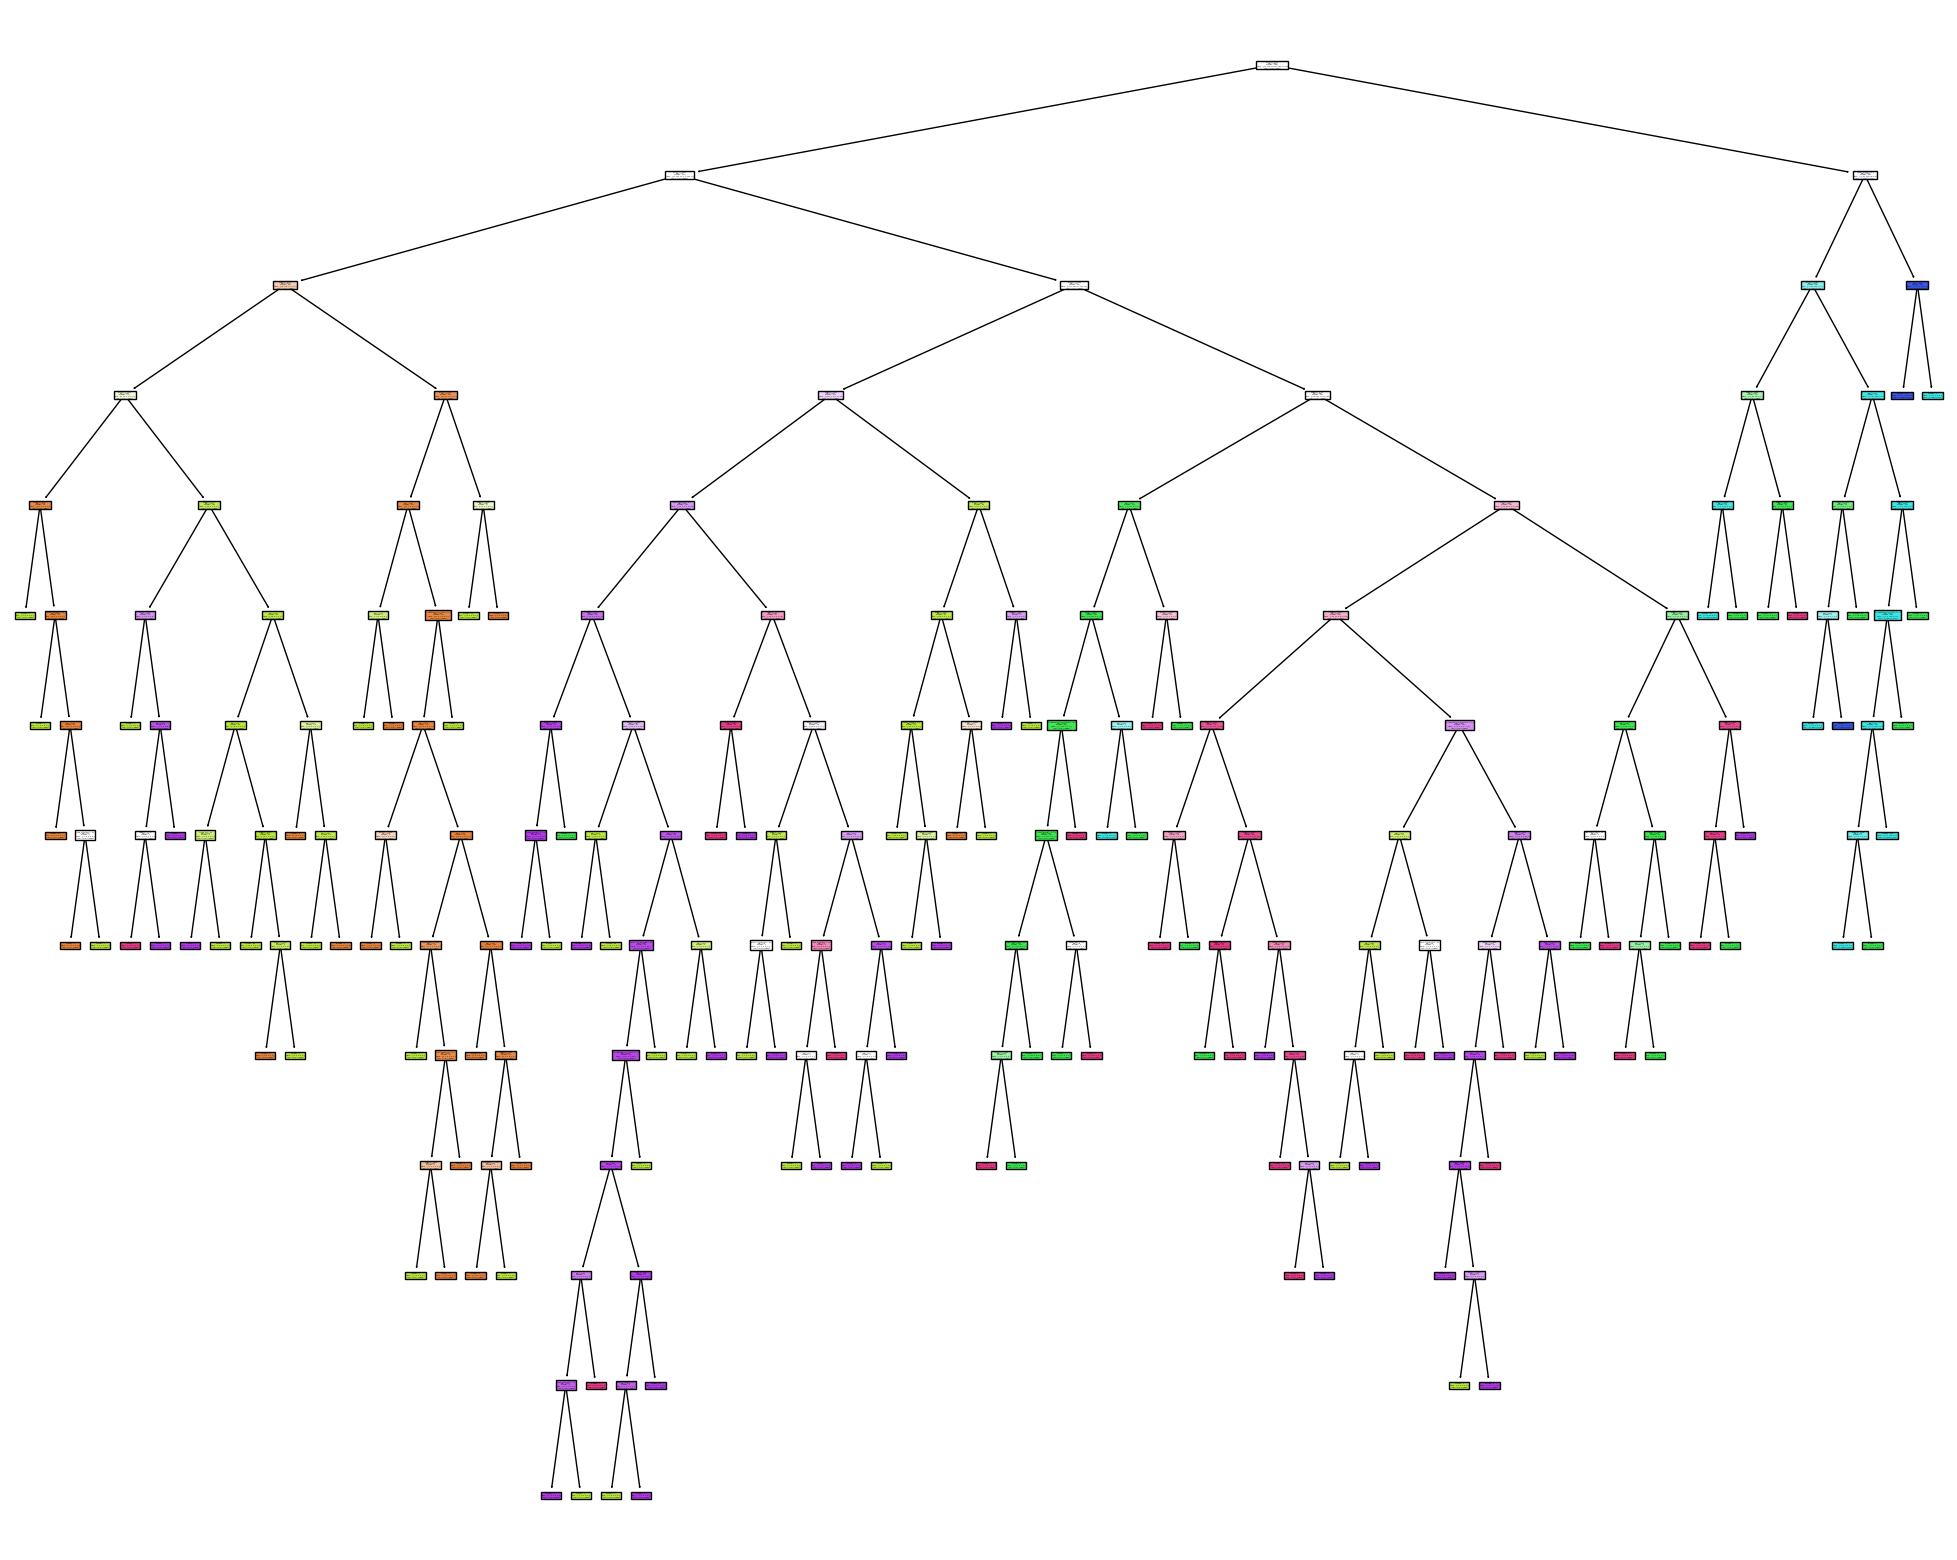

In [15]:
# visualization of baseline decision tree classifier
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(base_dt, 
                   feature_names=X.columns,  
                   class_names=y,
                   filled=True)

In [12]:
# initialize final decision tree classifier with found hyperparameters
final_dt = DecisionTreeClassifier(criterion='entropy', max_depth=11, splitter='best')

final_dt.fit(X_train, y_train)

final_preds = final_dt.predict(X_test)

print(classification_report(y_test, final_preds))

                     precision    recall  f1-score   support

Insufficient_Weight       0.98      0.92      0.95        65
      Normal_Weight       0.85      0.93      0.89        57
     Obesity_Type_I       0.96      0.97      0.96        67
    Obesity_Type_II       0.96      0.96      0.96        53
   Obesity_Type_III       1.00      1.00      1.00        69
 Overweight_Level_I       0.91      0.91      0.91        57
Overweight_Level_II       0.98      0.95      0.96        55

           accuracy                           0.95       423
          macro avg       0.95      0.95      0.95       423
       weighted avg       0.95      0.95      0.95       423



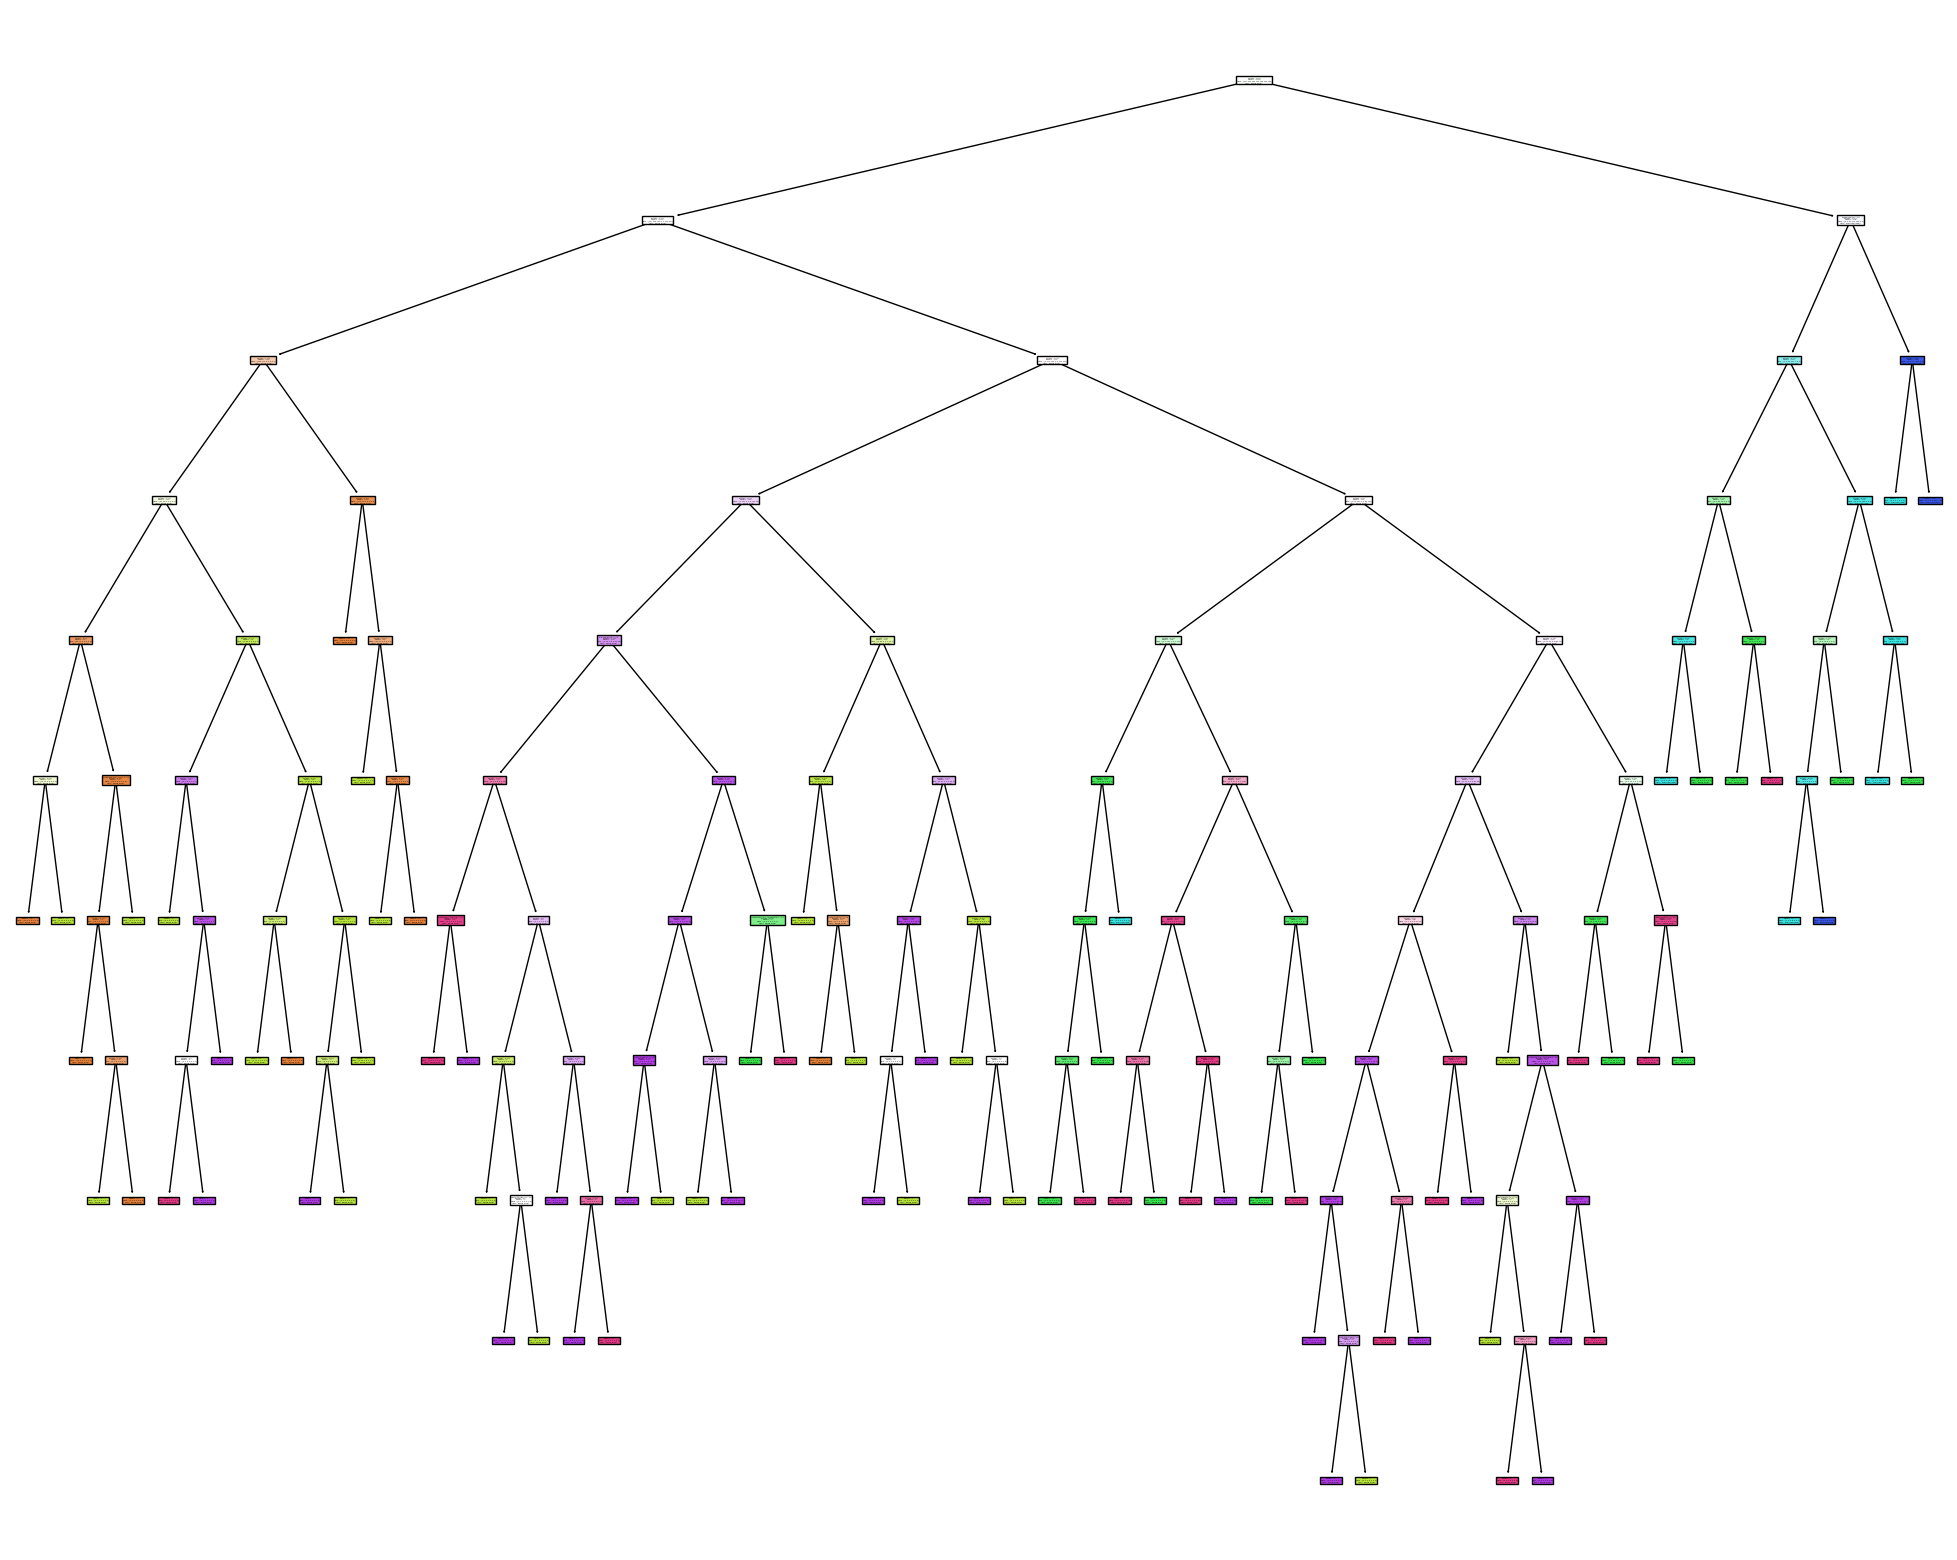

In [13]:
# visualization of final decision tree classifier
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(final_dt, 
                   feature_names=X.columns,  
                   class_names=y,
                   filled=True)

After performing cross validation and hyperparameter tuning on `criterion`, `splitter`, and `max_depth`, we see that the best hyperparameters for our final decision tree classification model without overfitting to the data are `entropy`, `best`, and `11`, respectively. We implemented a new decision tree classification model with our tuned hyperparameters and produced an accuracy score of **0.95**, which is an improvement from our baseline model and a very high accuracy score. Essentially, we were able to correctly classify 95% of the dataset, showing us this is a very high performing model.

Key Takeaways:

1. The dataset we worked with performed significantly better with a classification model when compared to the very low performance of clustering. Looking at our dataset and knowing what we do about clustering, this conclusion makes sense because there does not seem to be singular features that contribute to each respective obesity or weight class, but rather all features contributing together to the classification of weight classes. Also, our observations are likely independent of each other, so we do not see covariance among observations to show any strong local relationships for clustering.
2. The features in the dataset were good at classifying our observations for obesity and overweight levels, this means that there are strong associations amongst our features and the classes assigned to the different weight categories.
3. Looking at our visualizations, we have very large decision trees for classification. Considering that we have many labels for classification and 31 features that our model is selecting between, these visualizations are in line with the algorithms that we implemented.

# Subsections

## Subsection 1: Data Visualization and Model Selection

The dataset that we have provided showcases seventeen variables that are possible contributors to different levels of obesity. To determine what model woul be effecient, we performed data visualization using PCA, UMAP, and tSNE. Of these three methods, tSNE allowed us to infer the most. Our PCA visualization resulted in a plot with many overlapping points, making it difficult to differentiate between different types of obesity. The UMAP visualization plotted a tightly packed cluster that was not useful for our analysis. The tSNE visualization exhibits a better representation, it captures the local relationships between points, however the data does not seem to adhere to the classic assumptions of classic models. Due to the distribution of the data being high dimensional, we came to the conclusion that Kmeans and KNN would not be our best algorithm to use.

Below is our code spliting our data set into training and testing sets, utilizing this we performed tSNE.

### tSNE Visualization
Below this code transforms the training data (X_train) into two dimensions using t-SNE with a perplexity of 20 and a random state of 99. The resulting two-dimensional representation is stored in a DataFrame (tcs), with additional labels denoting the obesity type extracted from the target variable (y_train). The code then plots this transformed data, where each point is colored according to its ground truth obesity type. This visualization aids in understanding the underlying structure of the data and the distribution of different obesity types

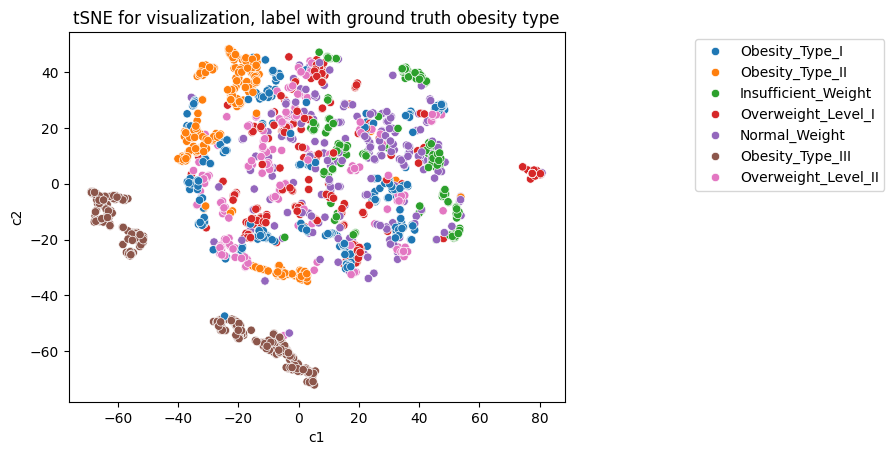

In [22]:
tsne_perp_20 = TSNE(n_components = 2, perplexity = 20, random_state = 99)
tcs = tsne_perp_20.fit_transform(X_train)
# construct the data frame
tcs = pd.DataFrame(tcs,columns=['c1','c2'])
tcs.index = X_train.index

tcs['obesity_type'] = y_train

sns.scatterplot(data=tcs, x='c1', y='c2', hue='obesity_type')
plt.title('tSNE for visualization, label with ground truth obesity type')
ax = plt.gca()
ax.legend(bbox_to_anchor=(1.25, 1))



### KMeans Model
Utilizing the kneelocator method, we can visualize the graph across a range of clusters to pinpoint where the decline in clusters occurs. This visual assessment aids in determining an optimal number of clusters for our dataset. By identifying the point where the rate of change diminishes significantly, we can establish a suitable range of clusters for subsequent analysis. This approach enhances our ability to select an appropriate number of clusters, contributing to the effectiveness of our clustering algorithm



The code below performs silhouette analysis for KMeans clustering on the high-dimensional data represented by X_train. It iterates over a range of cluster numbers (3, 4, and 5), creating silhouette plots to assess the quality of clustering. The plots visualize these coefficients for each cluster, with the average silhouette score marked by a dashed red line. Additionally, the code applies KMeans clustering to the high-dimensional data and visualizes the resulting clusters on a t-SNE transformed two-dimensional space (c1 and c2).

For n_clusters = 3 The average silhouette_score is : 0.1251921814921334
For n_clusters = 4 The average silhouette_score is : 0.134411129439368
For n_clusters = 5 The average silhouette_score is : 0.13128396736030623


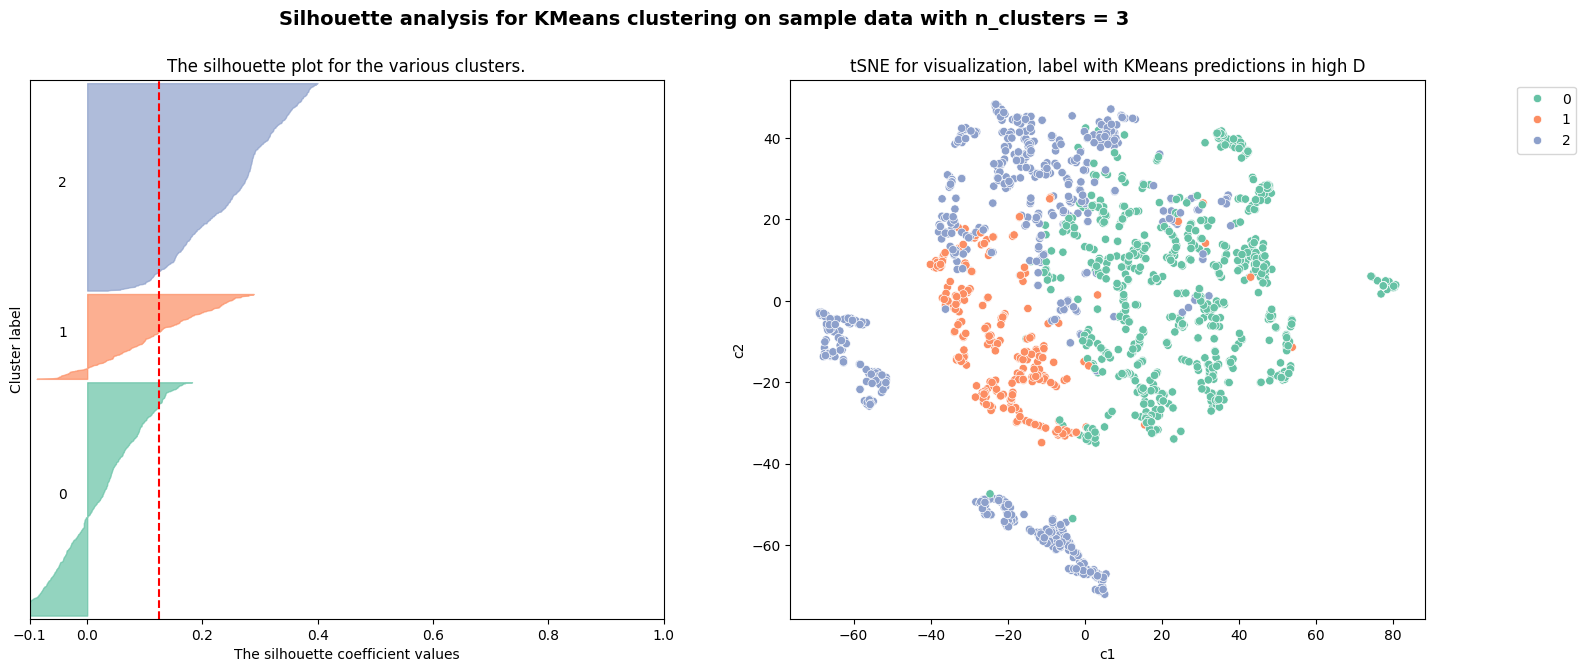

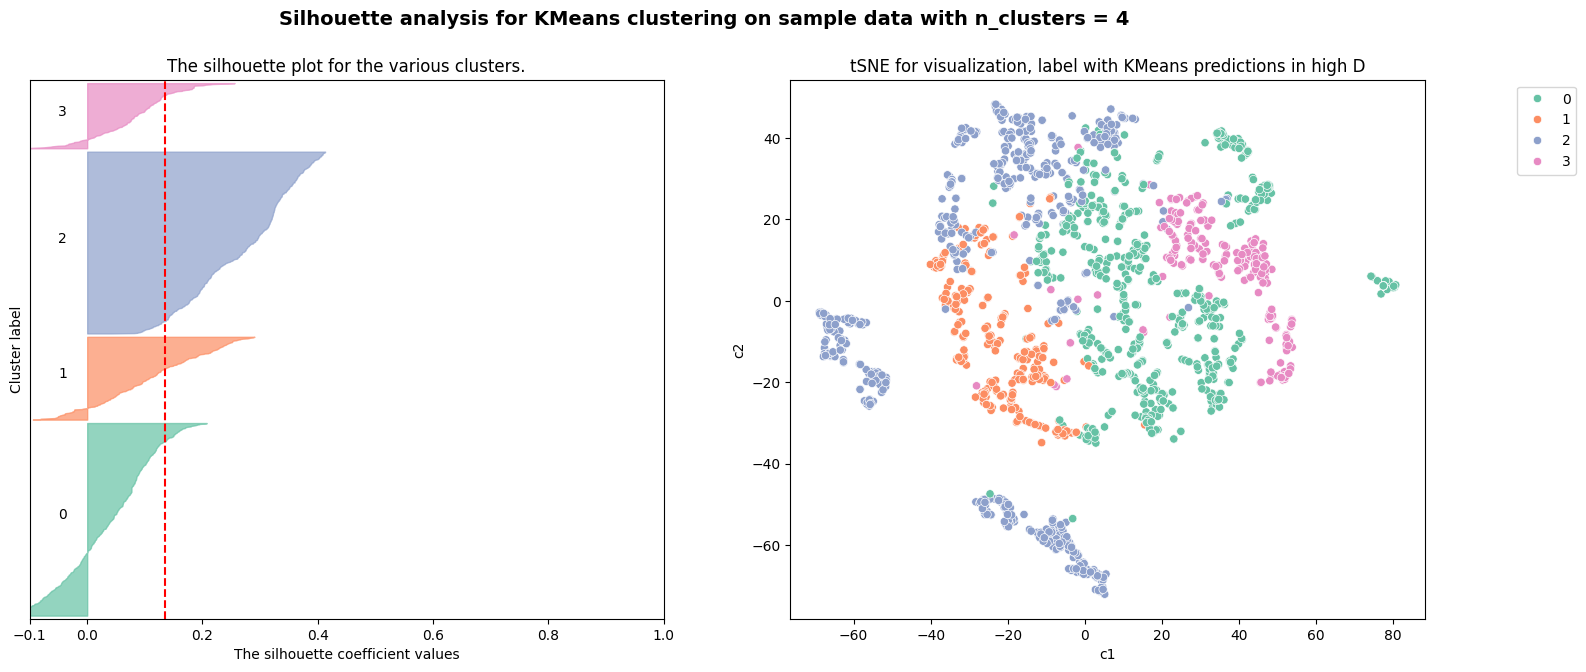

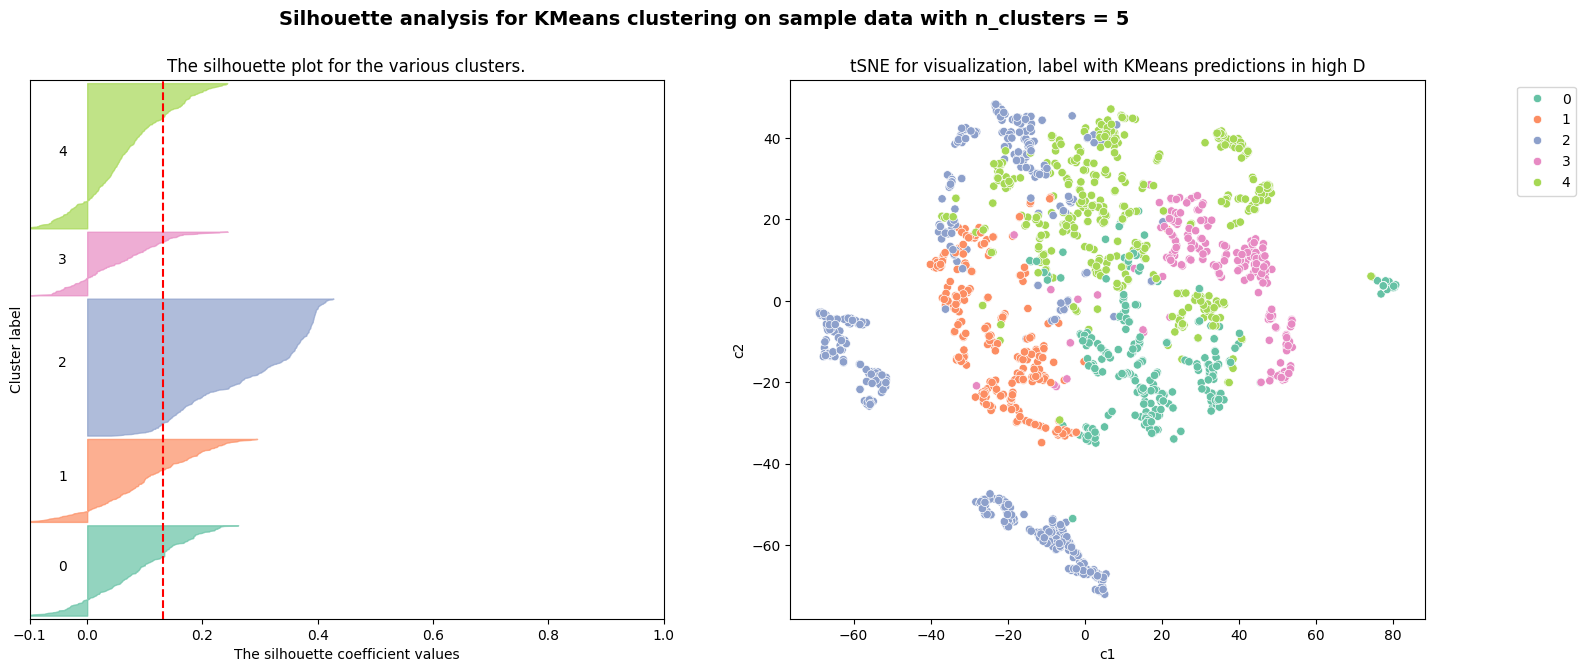

In [26]:
##copy/pasted from lecture notebook 19 and edited to be used for our data
### copy/pasted with some mods from https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html

import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np

from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn.metrics import silhouette_samples, silhouette_score

X= X_train.values #turn into numpy

range_n_clusters = [3, 4, 5] #Determined by the elbow above

for n_clusters in range_n_clusters:
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)
    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = cluster.KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = sns.color_palette('Set2', n_clusters)[i]
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    
    predicted = clusterer.predict(X)
    tcs['prediction'] = predicted
    sns.scatterplot(data=tcs, x='c1', y='c2', hue='prediction', 
                    palette='Set2', ax=ax2)
    plt.title('tSNE for visualization, label with KMeans predictions in high D')
    ax2.legend(bbox_to_anchor=(1.25, 1));

    plt.suptitle(
        "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
        % n_clusters,
        fontsize=14,
        fontweight="bold",
    )

plt.show()

In analyzing the silhouette plots generated from the KMeans clustering algorithm, it becomes evident that this method may not be suitable for our dataset. The observed discrepancies in silhouette shapes across different cluster numbers suggest a lack of clear separation between clusters. Consistent with our previous exploration using t-SNE, this indicates that KMeans may not effectively capture the underlying structure of our data. As a result, we will explore alternative clustering techniques, starting with DBSCAN, to better uncover meaningful patterns within our dataset.

## Subsection 2: DBSCAN 
Following the t-SNE transformation of our data, our next step involves assessing the local density of data points. We achieve this by employing the Nearest Neighbors model to measure the proximity between points. Identifying the 'elbow' in the distance plot allows us to determine an appropriate starting point for the epsilon (eps) value when configuring our DBSCAN algorithm. This approach enables us to initiate DBSCAN clustering with a well-informed parameter setting, thereby enhancing our ability to uncover meaningful clusters within the data.

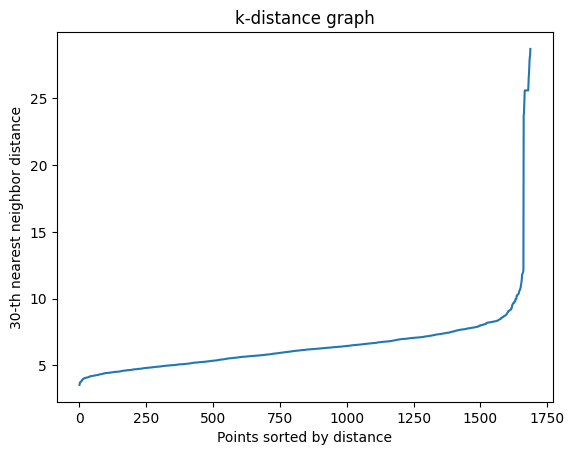

In [27]:
tsne = TSNE(n_components=2, perplexity=20, method='barnes_hut', n_iter=1000, random_state=99)
tcs = tsne.fit_transform(X_train)

# Compute the distances to kth nearest neighbors
k = 30  # You may need to adjust this value based on your data
nbrs = NearestNeighbors(n_neighbors=k).fit(tcs)
distances, _ = nbrs.kneighbors(tcs)
distances = np.sort(distances[:, -1])

# Plot the sorted distances
plt.plot(distances)
plt.title('k-distance graph')
plt.xlabel('Points sorted by distance')
plt.ylabel(f'{k}-th nearest neighbor distance')
plt.show()


After examining the elbow plot, we observed a sharp increase in distance occurring approximately after k=8. Further experimentation revealed that at k=65, the elbow occurred around 12. To explore various potential epsilon (eps) values, we decided to test a range of values centered around these points. Consequently, we utilized the range between k=2 and k=12, with additional padding, to define the range of eps values for our DBSCAN algorithm. This approach enabled us to thoroughly assess the impact of different eps values on the clustering outcome, ensuring a comprehensive exploration of the parameter space.

In [28]:
best_score = -1
best_params = None

for eps in [8, 8.5, 9, 9.5, 10, 10.5, 11, 11.5, 12, 12.5, 13, 13.5, 14, 14.5]:  # Example values for eps
    for min_samples in [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, 120, 130, 140, 150]:  # Example values for min_samples
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        dbscan.fit(tcs)
        dbscan_labels = dbscan.labels_
        
        # Compute adjusted Rand index

        score = adjusted_rand_score(y_train, dbscan_labels)
        print(f"eps={eps}, min_samples={min_samples}, Adjusted Rand Index: {score}")

        # Update best score and parameters
        if score > best_score:
            best_score = score
            best_params = {'eps': eps, 'min_samples': min_samples}

print("Best parameters:", best_params)
print("Best Adjusted Rand Index:", best_score)


eps=8, min_samples=10, Adjusted Rand Index: 0.08343665355518369
eps=8, min_samples=20, Adjusted Rand Index: 0.08343665355518369
eps=8, min_samples=30, Adjusted Rand Index: 0.0890515033967522
eps=8, min_samples=40, Adjusted Rand Index: 0.12106687421160423
eps=8, min_samples=50, Adjusted Rand Index: 0.08974204350960772
eps=8, min_samples=60, Adjusted Rand Index: 0.05933358346571962
eps=8, min_samples=70, Adjusted Rand Index: 0.03183436285218195
eps=8, min_samples=80, Adjusted Rand Index: 0.0052118498172322265
eps=8, min_samples=90, Adjusted Rand Index: 0.0
eps=8, min_samples=100, Adjusted Rand Index: 0.0
eps=8, min_samples=110, Adjusted Rand Index: 0.0
eps=8, min_samples=120, Adjusted Rand Index: 0.0
eps=8, min_samples=130, Adjusted Rand Index: 0.0
eps=8, min_samples=140, Adjusted Rand Index: 0.0
eps=8, min_samples=150, Adjusted Rand Index: 0.0
eps=8.5, min_samples=10, Adjusted Rand Index: 0.08343665355518369
eps=8.5, min_samples=20, Adjusted Rand Index: 0.08343665355518369
eps=8.5, min_

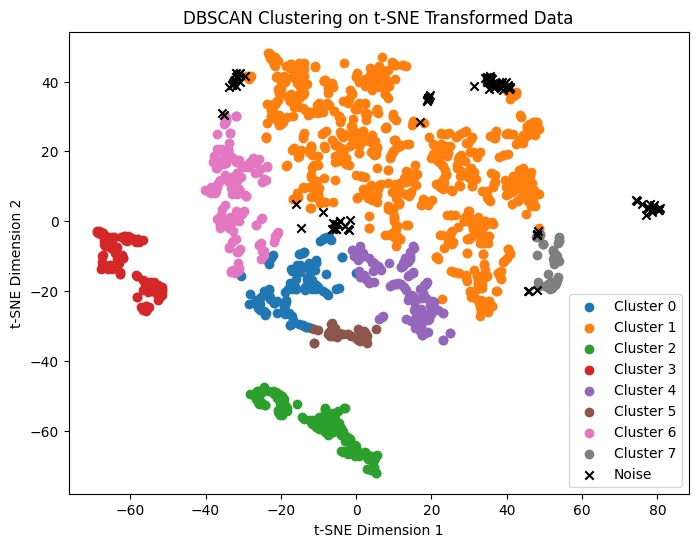

In [29]:
# Apply DBSCAN on the transformed data
dbscan = DBSCAN(eps=8, min_samples=40)
dbscan.fit(tcs)

# Extract cluster labels
cluster_labels = dbscan.labels_

# Number of clusters (ignore noise, represented by -1)
n_clusters = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)

# Plot the clusters
plt.figure(figsize=(8, 6))
for i in range(n_clusters):
    plt.scatter(tcs[cluster_labels == i][:, 0], tcs[cluster_labels == i][:, 1], label=f'Cluster {i}')
plt.scatter(tcs[cluster_labels == -1][:, 0], tcs[cluster_labels == -1][:, 1], color='black', marker='x', label='Noise')
plt.title('DBSCAN Clustering on t-SNE Transformed Data')
plt.xlabel('t-SNE Dimension 1')
plt.ylabel('t-SNE Dimension 2')
plt.legend()
plt.show()

#### Building Pipeline to Train Models

In [30]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.manifold import TSNE
from sklearn.datasets import make_classification

class TestTSNE(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.n_components = 2
        self.method = 'barnes_hut'
        self.n_iter = 1000
        self.random_state = 99
        self.perplexity = 20

    def fit(self, X, y = None):
        ts = TSNE(n_components = self.n_components, perplexity = self.perplexity, method = self.method, n_iter = self.n_iter, random_state = self.random_state)
        self.embedding_ = ts.fit_transform(X)
        return self

    def transform(self, X, y = None):
        return X
    
    
class DBSCANTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.eps = 13
        self.min_samples = 100

    def fit(self, X, y=None):
        self.dbscan_ = DBSCAN(eps=self.eps, min_samples=self.min_samples)
        self.dbscan_.fit(X)
        return self

    def transform(self, X):
        return np.column_stack([X, self.dbscan_.labels_])
    
    def predict(self, X):
        return self.dbscan_.fit_predict(X)
    
scaler = StandardScaler()
knn = KNeighborsClassifier(n_neighbors=20)

pipe = Pipeline([
    ('tsne', TestTSNE()),
#     ('scaler', scaler),  # Scale the data after dimensionality reduction
    ('dbscan', DBSCANTransformer()),
#     ('knn', knn) # adding knn in the pipeline would perform another classification which is not what we want
])


# if you want to make a pipeline for knn, make a new one

pipe.fit(X_train, y_train)

Pipeline(steps=[('tsne', TestTSNE()), ('dbscan', DBSCANTransformer())])

Text(0, 0.5, 'TSNE Embedding Dimension 2')

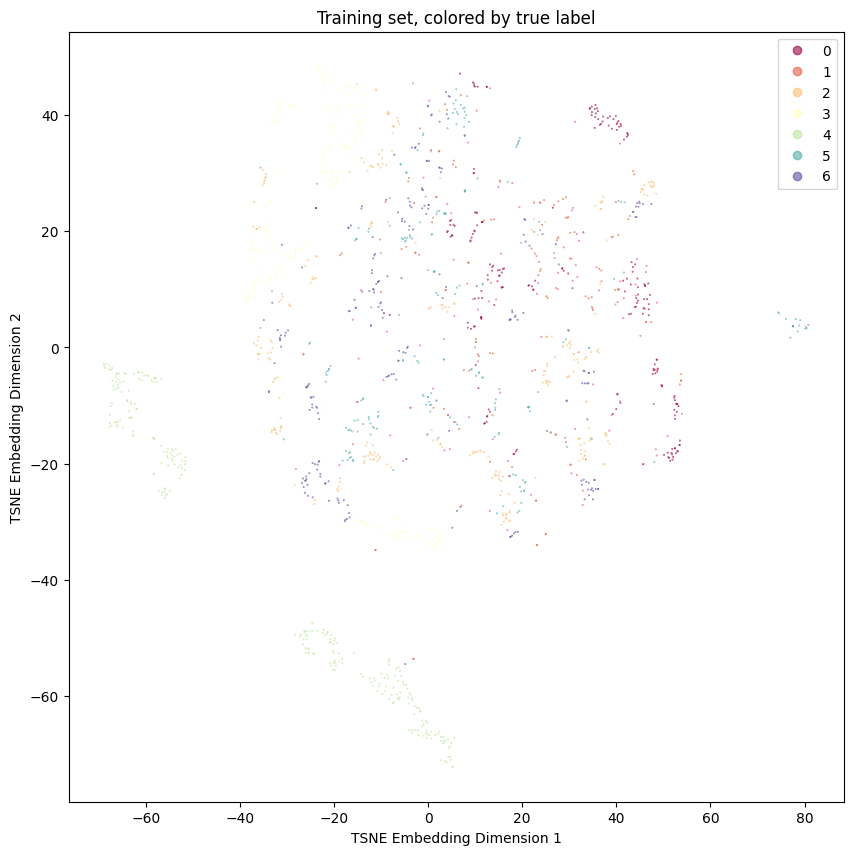

In [31]:
embedding_train = pipe.steps[0][1].embedding_
label_encoder = LabelEncoder()

# Encode categorical labels to numerical values
y_train_encoded = label_encoder.fit_transform(y_train)

plt.figure(figsize=(10, 10))
scatter = plt.scatter(embedding_train[:, 0], embedding_train[:, 1], c=y_train_encoded.astype(int), s=0.1, cmap='Spectral')
handles, _ = scatter.legend_elements(prop="colors", alpha=0.6) # use my own labels
legend1 = plt.legend(handles, np.arange(0, 10))
plt.title('Train set, colored by prediction')
plt.title('Training set, colored by true label')
plt.xlabel("TSNE Embedding Dimension 1")
plt.ylabel("TSNE Embedding Dimension 2")

In [32]:
prediction = pipe.predict(X_test)
y_test_encoded = label_encoder.fit_transform(y_test)
prediction_encoded = label_encoder.fit_transform(prediction)
print(classification_report(y_test_encoded, prediction_encoded))

              precision    recall  f1-score   support

           0       0.15      1.00      0.27        65
           1       0.00      0.00      0.00        57
           2       0.00      0.00      0.00        67
           3       0.00      0.00      0.00        53
           4       0.00      0.00      0.00        69
           5       0.00      0.00      0.00        57
           6       0.00      0.00      0.00        55

    accuracy                           0.15       423
   macro avg       0.02      0.14      0.04       423
weighted avg       0.02      0.15      0.04       423



## Subsection 3: Exploring other Models

For our next modeling approach, we considered Hierarchical Clustering. In this test, we opted to perform clustering directly on the original X_train data, rather than on the t-SNE dimension-reduced data. This approach allows us to explore the clustering patterns present in the original feature space. By applying Hierarchical Clustering to the original data, we aim to gain insights into the inherent structure and relationships among the features, potentially uncovering meaningful clusters that may not be apparent in the reduced-dimensional space.

In [33]:
# Taken from class notes
# things we will need to do stuff in this notebook
from scipy import stats
from numpy.linalg import norm
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from sklearn.preprocessing import StandardScaler


# two useful data viz libraries
import matplotlib.pyplot as plt
import seaborn as sns
def all_linkages(data):


   tree_sing = linkage(data,method='single')
   tree_cplt = linkage(data,method='complete')
   tree_avrg = linkage(data,method='average')
   tree_ward = linkage(data,method='ward')


   fig, axs = plt.subplots(2,2, figsize=(12,12))


   dendrogram(tree_sing, ax=axs[0,0])
   axs[0,0].set_title('Single linkage')
   xlim = axs[0,0].get_xlim()
   axs[0,0].set_yticks([])
   axs[0,0].set_xticks([])
   axs[0,0].set_xlim(xlim)




   dendrogram(tree_cplt, ax=axs[0,1])
   axs[0,1].set_title('Complete linkage')
   axs[0,1].set_yticks([])
   axs[0,1].set_xticks([])


   dendrogram(tree_avrg, ax=axs[1,0])
   axs[1,0].set_title('Average linkage')
   axs[1,0].set_yticks([])
   axs[1,0].set_xticks([])


   dendrogram(tree_ward, ax=axs[1,1])
   axs[1,1].set_title('Ward linkage');
   axs[1,1].set_yticks([])
   axs[1,1].set_xticks([])


   sns.despine(left=True, bottom=True)
  
   return tree_sing, tree_cplt, tree_avrg, tree_ward
   

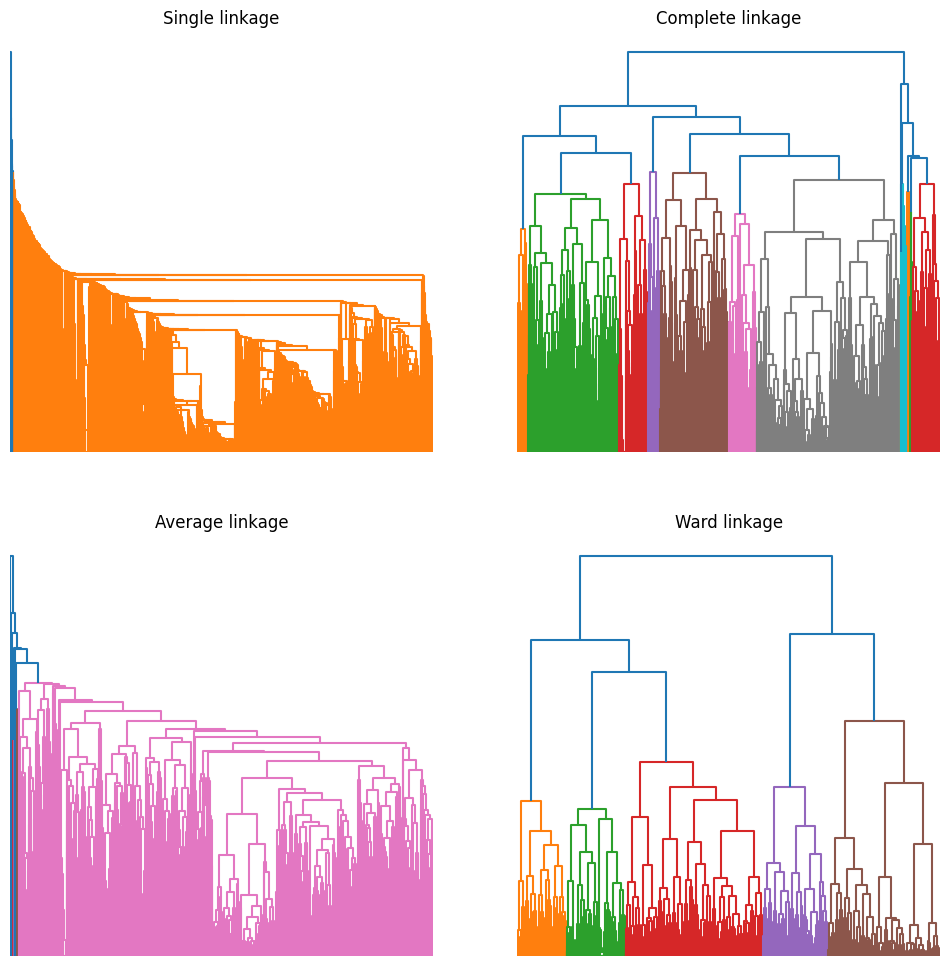

In [34]:
tree_sing, tree_cplt, tree_avrg, tree_ward = all_linkages(X_train)


Above, we plotted the graphs of the 4 types of linkage. Visually, we can see that Average and Single Linkage do not work well in clustering our data. However, Ward and Complete both seem to be viable options. Let us expand upon these two in more detail.


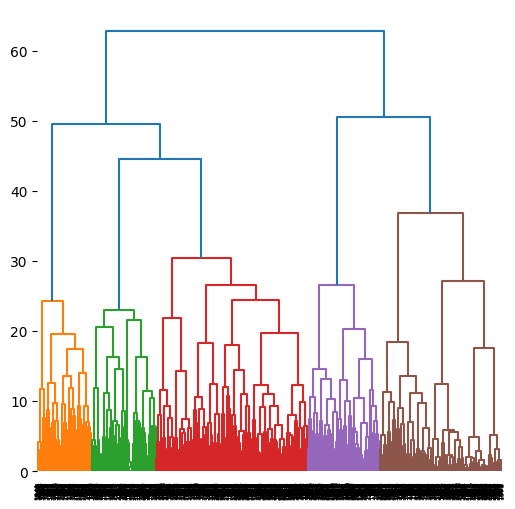

In [35]:
fig, ax = plt.subplots(figsize=(6,6))


dendrogram(tree_ward, ax=ax)
sns.despine(left=True,bottom=True)


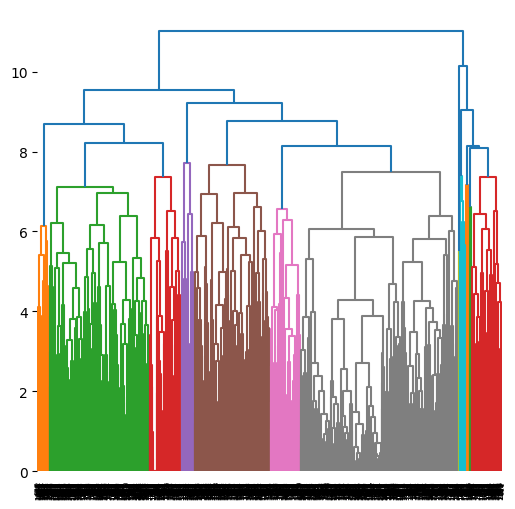

In [36]:
fig, ax = plt.subplots(figsize=(6,6))


dendrogram(tree_cplt, ax=ax)
sns.despine(left=True,bottom=True)

After plotting the two types of graphs we are considering, We can see that the optimal clustering distance for ward linkage is between 20 and 30, while the optimal clustering distance for complete linkage is between 8 to 10. Lets use these values to find the best parameters.

In [37]:
best_score = -1
best_params = None
best_type = None


for dist in [ 8, 8.5, 9, 9.5, 22, 23, 24, 25, 26, 27, 28, 29, 30]: 
   for type in [tree_ward, tree_cplt]: 
       clust = fcluster(type, criterion='distance', t=dist)
      
       # Compute adjusted Rand index
       score = adjusted_rand_score(y_train, clust)
       print(score, clust)
       # Update best score and parameters
       if score > best_score:
           best_score = score
           best_params = {'dist': dist}
           if np.array_equal(type, tree_ward):
               best_type = 'tree_ward'
           elif np.array_equal(type, tree_cplt):
               best_type = 'tree_cplt'


print("Best parameters:", best_params)
print("Best type:", best_type)
print("Best Adjusted Rand Index:", best_score)

0.12587852379381625 [66 68 61 ... 24 65 56]
0.15704702934334064 [2 1 1 ... 3 2 7]
0.1266469941280003 [60 61 56 ... 24 59 52]
0.14480933889055692 [2 1 1 ... 2 2 5]
0.1269375141042391 [53 54 49 ... 20 52 45]
0.07484543989997404 [1 1 1 ... 1 1 3]
0.12908144779319622 [47 48 43 ... 18 46 39]
0.06628826936234958 [1 1 1 ... 1 1 2]
0.220709861247327 [ 9 10  9 ...  4  9  8]
0.0 [1 1 1 ... 1 1 1]
0.220709861247327 [ 9 10  9 ...  4  9  8]
0.0 [1 1 1 ... 1 1 1]
0.21410649336181933 [8 9 8 ... 3 8 7]
0.0 [1 1 1 ... 1 1 1]
0.21400206867279617 [6 7 6 ... 2 6 5]
0.0 [1 1 1 ... 1 1 1]
0.21400206867279617 [6 7 6 ... 2 6 5]
0.0 [1 1 1 ... 1 1 1]
0.20518336891274686 [5 5 5 ... 2 5 4]
0.0 [1 1 1 ... 1 1 1]
0.273271761060468 [5 5 5 ... 2 5 4]
0.0 [1 1 1 ... 1 1 1]
0.273271761060468 [5 5 5 ... 2 5 4]
0.0 [1 1 1 ... 1 1 1]
0.273271761060468 [5 5 5 ... 2 5 4]
0.0 [1 1 1 ... 1 1 1]
Best parameters: {'dist': 28}
Best type: tree_ward
Best Adjusted Rand Index: 0.273271761060468


Despite the visually appealing results obtained from complete linkage clustering, further examination through print statements revealed its limited accuracy. Conversely, our best-performing parameters utilized the ward linkage method, with a cluster distance of 28 proving to be optimal. This observation, supported by the Adjusted Rand Index (ARI), suggests that Hierarchical Clustering is a valid approach for clustering our Obesity Data. The effectiveness of this model indicates its potential utility in uncovering meaningful clusters within our dataset.

# Discussion

### Interpreting the result

After extensive analysis, we concluded that our problem, coupled with the dataset, is better suited for a supervised learning approach rather than an unsupervised one.

Our exploration began with high-dimensional data, leading us to rule out KMeans due to its limitations in capturing the dataset's structure effectively. Subsequently, we explored DBSCAN, but its performance, with an accuracy of 0.15, fell short of our expectations.
This prompted us to delve deeper into supervised learning, specifically decision tree classification. The decision tree model yielded a remarkable accuracy of 0.94, demonstrating its effectiveness in categorizing factors related to different levels of obesity. Leveraging this supervised learning model, we can confidently classify and understand the factors influencing various obesity levels, providing valuable insights for our problem domain.

### Limitations

As we deliberated, our analysis revealed that our dataset yielded superior results with a supervised learning model. However, we recognized that the dataset's structure, characterized by numerous variables posing broad questions related to obesity levels, might benefit from a more specific inquiry approach. For instance, instead of asking binary questions like "Do you eat high-calorie food?", we could gather more precise information such as "What is your daily caloric intake?"

The dataset's abundance of features hindered the effectiveness of our attempts with DBSCAN, as it struggled to accurately discern patterns within the high-dimensional space. Had the dataset contained fewer features, DBSCAN might have produced more accurate results.
Additionally, the dataset's modest size, comprising only 2111 observations, posed challenges in effectively training our models. The limited data availability constrained our model's ability to generalize patterns and potentially impacted its predictive performance. Moving forward, we may explore strategies to augment our dataset or consider alternative modeling approaches to mitigate these limitations.  

### Ethics & Privacy

One concern would be in regards to how we collected subjects’ data. Since data was collected from UC Irvine Machine Learning Repository, we would consider this a reliable source. Data was collected through an online web platform with no names and personal information given, as it is completely anonymized. Because personal habits and physical condition can be a sensitive topic, we will make sure to protect the privacy of our subjects. In the case we encounter any additional data that alludes to participants personal information, we will make sure to anonymize them. Our population is from Mexico, Peru, and Columbia which are more racially homogenous populations than America. While there may be risk of sampling bias, we will make sure to choose data that is randomized across gender, age, and socioeconomic status. We do not believe our sampling will play a large effect on finding a conclusion to our research question.

Another concern would be whether our research question is ethically sound, or may have negative implications towards populations who suffer from obesity. We do not intend to use our findings to change or influence any population, nor use them to take any political or ethical stance.  We also cannot show that people from Mexico, Peru, or Columbia are more predisposed to obesity due to genetics or where they are from. The purpose of our research is to not discriminate against a certain population, rather to observe habits and whether they have a relationship with differing levels of obesity.

### Conclusion

In conclusion, our analysis indicates that clustering is not an optimal solution for categorizing different levels of obesity in our dataset. The overlapping nature of variables associated with various obesity levels complicates the clustering process.

Conversely, our decision tree classifier demonstrated that distinct levels of obesity are characterized by groups of features rather than individual variables. This finding suggests that supervised learning approaches, which consider the collective influence of multiple features, are better suited for classifying obesity levels accurately. Unlike clustering, which tends to rely on a single predominant feature for differentiation, decision tree classification can effectively leverage combinations of features to create more nuanced and accurate classifications.

# Footnotes
<a name="who"></a>1.[^](#who): “Obesity and overweight.” World Health Organization (WHO), 9 June 2021, https://www.who.int/news-room/fact-sheets/detail/obesity-and-overweight. Accessed 20 February 2024.<br> 
<a name="cdc"></a>2.[^](#cdc): “Adult Obesity Facts | Overweight & Obesity | CDC.” Centers for Disease Control and Prevention, https://www.cdc.gov/obesity/data/adult.html. Accessed 20 February 2024.<br>
<a name="niddk"></a>3.[^](#niddk): “Health Risks of Overweight & Obesity - NIDDK.” National Institute of Diabetes and Digestive and Kidney Diseases, https://www.niddk.nih.gov/health-information/weight-management/adult-overweight-obesity/health-risks. Accessed 20 February 2024.
